# Deep Learning Basic

In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn

## 从零开始实现线性回归

**数据生成**

In [2]:
n_dim = 2
n_data = 1000

w_gt = torch.tensor([2, -3.4])
b_gt = torch.tensor(4.2)

data = torch.randn(n_data, n_dim)
# label = w_gt.matmul(data.transpose(0, 1)) + b_gt
label = data.matmul(w_gt.unsqueeze(1)) + b_gt
label += torch.from_numpy(np.random.normal(0, 0.01, (n_data, 1))).to(torch.float32)

print(data.shape)
print(label.shape)
print(data[0], label[0])

torch.Size([1000, 2])
torch.Size([1000, 1])
tensor([-0.5557, -0.6386]) tensor([5.2476])


**数据可视化**

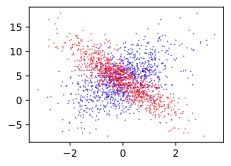

In [3]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize


set_figsize()
plt.scatter(data[:, 0].numpy(), label[:, 0].numpy(), 0.1, c='blue');
plt.scatter(data[:, 1].numpy(), label[:, 0].numpy(), 0.1, c='red');

**读取数据**

In [4]:
# # 补充： yield用法（模拟python2的xrange以及python3的range函数）
# def foo(num):
#     print("starting...")
#     i = 0
#     while i < num:
#         i += 1
#         yield i
# for n in foo(5):
#     print(n)


batch_size = 16

# # 方式一： 自己实现一个dataLoader
# def data_iter(data, label, batch_size):
#     n_data = data.shape[0]
#     indices = list(range(n_data))
#     random.shuffle(indices)
#     for i in range(0, n_data, batch_size):
#         j  = torch.LongTensor(indices[i: min(i + batch_size, n_data)])
#         yield data.index_select(0, j), label.index_select(0, j)
        
        
# for x, y in data_iter(data, label, 16):  # try one batch
#     print(x, '\n\n', y)
#     break

# 方式二： 直接使用torch.util.data模块的类
import torch.utils.data as Data
dataset = Data.TensorDataset(data, label)
data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

**定义模型**

In [5]:
# # 方式一： 自己实现一个模型
# def linear_reg(x, w, b):
#     return torch.mm(x, w) + b

# 方式二： 实现一个类，继承nn.module类, 重写forward函数
class LinearNet(nn.Module):
    def __init__(self, n_dim):
        super(LinearNet, self).__init__()
#         self.linear = nn.Linear(n_dim, 1, bias=True)  # 这里的size其实就是w的维度
        self.linear = nn.Sequential(*[nn.Linear(n_dim, 1, bias=True)])  # 也可以使用nn.Sequential

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

**定义损失函数**

In [6]:
# # 方式一： 自己实现一个loss
# def l2_loss(y_pred, y_gt):
#     return ((y_pred - y_gt) ** 2 / 2).mean()

# 方式二： 使用nn.MSELoss()
l2_loss = nn.MSELoss()

**定义优化算法**

In [7]:
lr = 1e-2

# # 方式一： 自己实现一个optimizer
# def sgd(params, lr, batch_size):
#     for param in params:
#         param.data -= lr * param.grad / batch_size  # 由于loss都是loss_batch.mean(), 所以这里要除以batch_size
    
    
# 方式二： 使用torch.optim
import torch.optim as optim

**训练模型**

In [8]:
# ================= Get the model ================
# net = linear_reg

net = LinearNet(2)
for param in net.parameters():
    print(param, '\n\n')
print(net, '\n\n', net.linear[0], '\n\n')

# ================= Get the loss ================
loss = l2_loss

# ================= Get the optimizer ================
# optimizer = sgd

optimizer = optim.SGD(net.parameters(), lr=0.01)
print(optimizer, '\n\n')

# ================= Initialize the vars ================
# w = torch.tensor(np.random.normal(0, 0.01, (n_dim, 1)), dtype=torch.float32)
# b = torch.zeros(1, dtype=torch.float32)
# w.requires_grad_(requires_grad=True)
# b.requires_grad_(requires_grad=True)

from torch.nn import init
init.normal_(net.linear[0].weight, mean=0.0, std=0.01)
init.constant_(net.linear[0].bias, val=0.0)

# ================= Starting to train ================
epochs = 20

# for epoch in range(1, epochs + 1):
#     for x, y_gt in data_iter(data, label, batch_size):
#         y_pred = net(x, w, b)
#         l = loss(y_pred, y_gt)
#         l.backward()
#         optimizer([w, b], lr, batch_size)
#         w.grad.data.zero_()
#         b.grad.data.zero_()
#     train_l = loss(net(data, w, b), label)
#     print('Epoch: {}, Loss: {:.5f}'.format(epoch, train_l))
# print(w, '\n\n', w_gt, '\n\n', b, '\n\n', b_gt)

for epoch in range(1, epochs + 1):
    for x, y_gt in data_iter:
        y_pred = net(x)
        l = loss(y_pred, y_gt)
        optimizer.zero_grad()  # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    train_l = loss(net(data), label)
    print('Epoch: {}, Loss: {:.5f}'.format(epoch, train_l))
print('\n\n', net.linear[0].weight.data, '\n\n', w_gt, '\n\n', net.linear[0].bias.data, '\n\n', b_gt, '\n\n')
        

Parameter containing:
tensor([[-0.3583,  0.1407]], requires_grad=True) 


Parameter containing:
tensor([0.0811], requires_grad=True) 


LinearNet(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
  )
) 

 Linear(in_features=2, out_features=1, bias=True) 


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
) 


Epoch: 1, Loss: 2.57778
Epoch: 2, Loss: 0.20052
Epoch: 3, Loss: 0.01578
Epoch: 4, Loss: 0.00132
Epoch: 5, Loss: 0.00020
Epoch: 6, Loss: 0.00010
Epoch: 7, Loss: 0.00010
Epoch: 8, Loss: 0.00010
Epoch: 9, Loss: 0.00010
Epoch: 10, Loss: 0.00010
Epoch: 11, Loss: 0.00010
Epoch: 12, Loss: 0.00010
Epoch: 13, Loss: 0.00010
Epoch: 14, Loss: 0.00010
Epoch: 15, Loss: 0.00010
Epoch: 16, Loss: 0.00010
Epoch: 17, Loss: 0.00010
Epoch: 18, Loss: 0.00010
Epoch: 19, Loss: 0.00010
Epoch: 20, Loss: 0.00010


 tensor([[ 2.0001, -3.3998]]) 

 tensor([ 2.0000, -3.4000]) 

 tensor([4.2002]) 

 tensor(4.2000) 


